In [1]:
from models import train_predict,CondensedGoogLeNet
from models.train_predict import get_confusion_matrix
from data.data_processing import generate_dummy_data,DataHandler,get_training_data_from_path
from config.hyperparams import GoogleNet_hyperparams
from backtest.backtest import Backtester


import tensorflow as tf
import pandas as pd
import numpy as np
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
folder_for_samples = 'data/cnn_samples'

# Data Processing

## Get stock data in Handler object

In [12]:
# path_to_dump_samples = os.path.join(folder_for_samples,'regular')
path_to_dump_samples = os.path.join(folder_for_samples,'close-1_week-2015_2018-16_pixels')

handler = DataHandler(encoding_method='GADF', window_len=64, image_size=16, retrain_freq=5,
                 start_date = 20150101, end_date= 20200102, frac_of_stocks=0.07,
                stock_data_dir_path= 'data/2019_stock_data',targets_methods=['close'],
                 dir_for_samples=path_to_dump_samples, nb_of_stocks_by_file=100,
                      kwargs_target_methods = {'up_return':0.012,'down_return':-0.012,'buy_on_last_date':True}
                 )

In [13]:
handler.get_df_data()

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

In [14]:
# handler.show_image(handler.df_data)

## Builds images and targets and creates pickles
+ Be careful for the folder name (specified in handler object), this function will delete all files in this folder before dumping pickles

In [15]:
handler.build_and_dump_images_and_targets()

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

C:\Users\elior illouz\Notebooks\Deep Learning\DeepLearningAllocationCNN\data\data_processing.py:313: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_res = pd.concat([df_res, df_res_one_permno])


# Training

## Retrieve data from the specified folder
+ '/regular' is the default to retrieve samples
+ '/VWAP_1_week_2015_2017_all_stocks' is another one

In [18]:
%%time

# path_to_retrieve_samples = folder_for_samples+'/regular'
path_to_retrieve_samples = folder_for_samples+'/close-1_week-2015_2018-16_pixels'



X_train, X_val, X_test, Y_train, Y_val, Y_test = get_training_data_from_path(samples_path=path_to_retrieve_samples,
                                targets_type='close',
                                train_val_size=2 / 3.,
                                train_size=0.75,
                                logger_env='Training')


Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

Wall time: 879 ms


## Build the neural network object and Train the network 
+ Choose your params BE CAREFUL about the path to drop the model_checkpoints
+ Choose or update hyperparameters
+ If you run restore = True Choose the checkpoint.meta file to use for the model to load

###### Then 

+ Choose parameters for the train_predict function 
+ Run the next cell to build the network object and train

In [19]:
shape_x,shape_y = list(X_train.shape),list(Y_train.shape)
shape_x[0],shape_y[0] = None,None

GoogleNet_hyperparams.update({'learning_rate':0.003,'dropout':0.1})

# penalty factor assigned for misclassifying i to j. It used to combine sample prior (distribution of classes in the training
# sample) to compute expected penalty of misclassifying i-th class
cost_matrix=np.array([[0, 1.1, 1.4], [1.1, 0, 1.1], [1.4, 1.1, 0]])

n_test = 5000
checkpoints_folder = 'model_checkpoints'
checkpoint_prefix = 'ckpt-close-1_week-2015_2018-16_pixels'
model_checkpoints_path = os.path.join(checkpoints_folder,checkpoint_prefix)

# X_train1, X_val1, Y_train1, Y_val1 =  X_train[:n_test], X_val[:n_test], Y_train[:n_test], Y_val[:n_test]
# X_train1, X_val1, Y_train1, Y_val1 =  X_train[n_test:], X_val[:n_test], Y_train[n_test:], Y_val[:n_test]
X_train1, X_val1, Y_train1, Y_val1 =  X_train, X_val, Y_train, Y_val



path_restore = (tf.train.latest_checkpoint('model_checkpoints') or '')+'.meta'

#### Run the training

In [ ]:
network = CondensedGoogLeNet(shape_x=shape_x,shape_y=shape_y,hyperparams=GoogleNet_hyperparams)


GN_pred, GN_training_loss, GN_val_loss = train_predict(X=X_train1, Y=Y_train1, batch_size=50, valX=X_val1, valY=Y_val1,
                                                       model_ckpt_path=model_checkpoints_path, is_bayesian=True,cost_matrix=cost_matrix,
                                                       epochs=4, net=network,save_step =2,cost_sensitive_loss=True,restore=False,
                                                       model_ckpt_path_to_restore=path_restore)

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

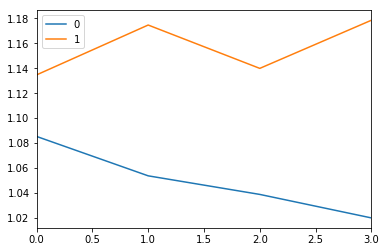

In [22]:
pd.DataFrame([GN_training_loss,GN_val_loss]).T.plot()

# Backtest

In [14]:
checkpoints_folder = 'model_checkpoints'
checkpoint_prefix = 'ckpt-close-1_week-2015_2018-16_pixels'
model_checkpoints_path = os.path.join(checkpoints_folder,checkpoint_prefix)

path_to_retrieve_samples = folder_for_samples+'/close-1_week-2015_2018-16_pixels'


model_checkpoints_path_file = model_checkpoints_path+'-400.meta'

backtester = Backtester(path_data=path_to_retrieve_samples,path_model_to_restore=model_checkpoints_path_file,start_date=20150406,end_date=20151103)

In [15]:
backtester.run_backtest()

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

(6000, 16, 16, 4)
INFO:tensorflow:Restoring parameters from model_checkpoints\ckpt-close-1_week-2015_2018-16_pixels-400


In [16]:
backtester.plot_backtest()

# Little tests section

In [ ]:
import tensorflow as tf

In [ ]:
tf.train.latest_checkpoint('model_checkpoints')

In [ ]:

# with tf.variable_scope('test',reuse=tf.AUTO_REUSE):
#     network2 = CondensedGoogLeNet(shape_x=shape_x,shape_y=shape_y,hyperparams=GoogleNet_hyperparams)
#     network2.build_operations()
sess=tf.Session()    
#First let's load meta graph and restore weights
# saver = tf.train.import_meta_graph('model_checkpoints/ckpt1-266.meta')
saver = tf.train.import_meta_graph('model_checkpoints/ckpt-26.meta')
saver.restore(sess,tf.train.latest_checkpoint('model_checkpoints'))

In [ ]:
graph = tf.get_default_graph()
# w1 = graph.get_tensor_by_name("w1:0")
# w2 = graph.get_tensor_by_name("w2:0")
# feed_dict ={w1:13.0,w2:17.0}



+ CondensedGoogLeNet/loss/Mean gets the loss
+ CondensedGoogLeNet/Adam gets the optimizer
+ CondensedGoogLeNet/accuracy/Mean gets the accuracy
    + we can get the validation error just after
+ CondensedGoogLeNet/Merge/MergeSummary gets the summary op
+ CondensedGoogLeNet/init gets init_op
+ 

In [ ]:
output = graph.get_tensor_by_name('CondensedGoogLeNet/output:0')
train_op = graph.get_tensor_by_name('CondensedGoogLeNet/minimize:0')
x = graph.get_tensor_by_name('CondensedGoogLeNet/x:0')
y = graph.get_tensor_by_name('CondensedGoogLeNet/y:0')
global_step = graph.get_tensor_by_name('CondensedGoogLeNet/global_step:0')
# loss = graph.get_tensor_by_name('CondensedGoogLeNet/loss/Mean:0')

In [ ]:
pred = sess.run([train_op,global_step],feed_dict={x:X_val[:100],y:Y_val[:100]})

In [ ]:
pred

In [ ]:
network.optimizer

In [ ]:
# train_op = graph.get_tensor_by_name('CondensedGoogLeNet/minimize:0')


In [ ]:
train_op

In [ ]:
pred

In [ ]:
pred = sess.run(output,feed_dict={x:X_val1[:15]})
pred

In [ ]:
saver.save(sess,'model_checkpoints/test_restore')

In [ ]:
pd.DataFrame(np.max(pred,axis=1)).hist(bins=100)

In [ ]:
pred[:5]

In [ ]:
GN_pred[:5]

In [ ]:
Y_val[:5]

In [ ]:
pred.shape

In [ ]:
tf.reset_default_graph()

# Create some variables.
v1 = tf.get_variable("v1", shape=[3])
v2 = tf.get_variable("v2", shape=[5])

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
  # Restore variables from disk.
  saver.restore(sess, "/tmp/model.ckpt")
  print("Model restored.")
  # Check the values of the variables
  print("v1 : %s" % v1.eval())
  print("v2 : %s" % v2.eval())

In [ ]:
tf.train.latest_checkpoint

In [ ]:
tf.train.import_meta_graph